In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

from skopt import gp_minimize
from skopt.space import Integer, Real

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_lorenz


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, return_hilbert_x0
from tools.ae_v2 import Autoencoder
from tools.ESN_v1 import ESN
from tools.ESN_v1_ensembleAR import ESN_ensemble as AR_RNN
from tools.AEESN_AR_v1 import AR_AERNN_ESN as AR_AERNN
from tools.hyper_param_ESN import trainESN_and_return_PH

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            # tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
            tf.config.set_visible_devices([], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[]


2023-07-17 17:34:19.231808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-17 17:34:19.312006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-17 17:34:19.312297: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-17 17:34:19.313389: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU')]
2.8.1


# Lorenz System

In [12]:
# setting up params (and saving, if applicable)
# from numpy import *

# making RNN save directory
dir_name_rnn = os.getcwd() + dir_sep + 'ESN_params_Search'
if not os.path.isdir(dir_name_rnn):
    os.makedirs(dir_name_rnn)

counter = 0
while True:
    dir_check = 'params_search_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
        counter += 1
    else:
        break

dir_name_rnn = dir_name_rnn + dir_sep + dir_check
os.makedirs(dir_name_rnn)
dir_name_rnn_plots = dir_name_rnn+dir_sep+'plots'
os.makedirs(dir_name_rnn_plots)

# whether to use AE data or just work on raw data
use_ae_data = True # if false, specifying ae_idx will only show which dataset to use

# autoencoder directory
# ae_idx = '046'
# dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_024'.format(ds=dir_sep)

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/ESN_params_Search/params_search_005
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae/ae_024
data_dir_idx: 010
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.9058021372262592, lyapunov time : 1.1039938926696777s


In [14]:
positve_lp_idx = np.where(lyapunov_time_arr > 0)[0]
print(positve_lp_idx)

[0]


In [15]:
last_idx = all_data.shape[0]
temp_bia = np.zeros(shape=1+boundary_idx_arr.shape[0], dtype=np.int32)
temp_bia[1:] = boundary_idx_arr
print(temp_bia)
for i in range(boundary_idx_arr.shape[0]-1, -1, -1):
    if not (i in positve_lp_idx):
        print(i)
        num_idxs = last_idx - temp_bia[i+1]
        all_data[temp_bia[i]:temp_bia[i]+num_idxs] = all_data[temp_bia[i+1]:last_idx]
        last_idx = last_idx - (temp_bia[i+1]-temp_bia[i])

[      0 4200001]


In [16]:
new_bia = np.empty_like(boundary_idx_arr)
new_bia[:] = boundary_idx_arr
new_pmat = np.empty_like(params_mat)
new_pmat[:, :] = params_mat
counter = 0
bia_counter = boundary_idx_arr.shape[0]
for i in range(boundary_idx_arr.shape[0]):
    if not (i in positve_lp_idx):
        new_bia[i:] -= temp_bia[i+1] - temp_bia[i]
        new_bia[i:bia_counter-1] = new_bia[i+1:bia_counter]
        new_pmat[i:bia_counter-1] = new_pmat[i+1:bia_counter]
        bia_counter -= 1

In [17]:
new_bia = new_bia[0:bia_counter]
new_pmat = new_pmat[0:bia_counter]

In [18]:
all_data = all_data[0:new_bia[-1]]

In [19]:
new_bia, boundary_idx_arr = boundary_idx_arr, new_bia
new_pmat, params_mat = params_mat, new_pmat

In [20]:
# delaing with normalizing the data before feeding into autoencoder
num_params = params_mat.shape[1]
og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

time_stddev_ogdata = np.std(all_data[:, 0:og_vars], axis=0)
time_mean_ogdata = np.mean(all_data[:, 0:og_vars], axis=0)
    
if use_ae_data == True:
    if ae_data_with_params == True and alldata_withparams_flag == False:
        new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
        new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
        del(all_data)
        all_data = new_all_data
        prev_idx = 0
        for i in range(boundary_idx_arr.shape[0]):
            all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
            prev_idx = boundary_idx_arr[i]

    if normalizeforae_flag == True:
        for i in range(all_data.shape[1]):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:og_vars]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:og_vars]

# Autoencoder

In [21]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [22]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [23]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    # del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

# ESN

In [24]:
# RNN data parameters
dt_rnn = 0.1
num_input_tsteps = 20000
T_sample_input = num_input_tsteps*dt_rnn
T_sample_output = T_sample_input
T_offset = dt_rnn
normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
normalization_arr = None
stddev_multiplier = 3
skip_intermediate = 'full sample'
noise_type = 'normal' # can be 'uniform' or 'normal'
normalization_type = 'stddev' # can be 'minmax' or 'stddev', if it is
                              # 'minmax' then stddev_multiplier has no effect
ESN_layers_units = [num_latent_states*200]
stateful = True
omega_in_x0 = 1.0
degree_of_connectivity_x0 = 3
rho_res_x0 = 0.8
usebias_Win = [False]
alpha_x0 = 0.99
ESN_cell_activations = ['tanh']
usebias_Wout = True

activation_post_Wout = 'linear'
use_weights_post_dense = False

vary_deg_connect = False # whether to search for degree_of_connectivity or use it as a constant

if return_params_arr != False:
    params = params_arr
else:
    params = None

# saving simulation data
sim_data = {
    'params_mat':params_mat,
    'init_state_mat':init_state_mat,
    't0':t0,
    'T':T,
    'delta_t':delta_t,
    'return_params_arr':return_params_arr,
    'dir_name_ae':dir_name_ae,
    'normalize_dataset':normalize_dataset,
    'stddev_multiplier':stddev_multiplier,
    'use_ae_data':use_ae_data,
    'vary_deg_connect':vary_deg_connect,
}

# saving RNN specific data
RNN_specific_data = {
    'dt_rnn':dt_rnn,
    'T_sample_input':T_sample_input,
    'T_sample_output':T_sample_output,
    'T_offset':T_offset,
    'boundary_idx_arr':boundary_idx_arr,
    'delta_t':delta_t,
    'params':params,
    'return_params_arr':return_params_arr,
    'normalize_dataset':normalize_dataset,
    'num_input_tsteps':num_input_tsteps,
    'stddev_multiplier':stddev_multiplier,
    'skip_intermediate':skip_intermediate,
    'module':ESN.__module__,
    'noise_type':noise_type,
    'normalization_type':normalization_type,
}

In [25]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [26]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [27]:
rnn_res_dict = create_data_for_RNN(
    all_data,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=False,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
AR_data_rnn_input = rnn_res_dict['data_rnn_input']
AR_data_rnn_output = rnn_res_dict['data_rnn_output']
AR_org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
AR_org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
AR_num_samples = rnn_res_dict['num_samples']
AR_normalization_arr = rnn_res_dict['normalization_arr']
AR_rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

del(AR_org_data_idx_arr_input)
del(AR_org_data_idx_arr_output)
del(AR_rnn_data_boundary_idx_arr)

del(all_data)

In [28]:
print(data_rnn_input.shape)

(20, 20000, 2)


In [29]:
# setting up training params
num_ensemble_mems = 5
epochs = 1
lambda_reg_x0 = 1e-7 # weight for regularizer
min_delta = 1e-6
patience = 5
train_split = 0.8
val_split = 0.1
test_split = 1 - train_split - val_split
batch_size = 1
fRMS_x0 = 1e-3
use_best = False

# ph computation parameters
num_runs = 100
T_sample_input_AR_ratio = 1
T_sample_output_AR_ratio = 4

# saving training params
training_specific_params = {
    'epochs':epochs,
    'prng_seed':prng_seed,
    'train_split':train_split,
    'val_split':val_split,
    'batch_size':batch_size,
    'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
    'min_delta':min_delta,
    'patience':patience,
    'use_best':use_best,
    'degree_of_connectivity_x0':degree_of_connectivity_x0,
}

In [30]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train_arr[i] = batch_size * int( np.round(train_split*num_samples/batch_size) )
    num_val_arr[i] = batch_size * int( np.round(val_split*num_samples/batch_size) )
    num_test_arr[i] = batch_size * int( np.round((num_samples - num_train_arr[i] - num_val_arr[i])/batch_size) )
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape, dtype=FTYPE)
training_data_rnn_output = np.empty(shape=training_output_shape, dtype=FTYPE)

val_data_rnn_input = np.empty(shape=val_input_shape, dtype=FTYPE)
val_data_rnn_output = np.empty(shape=val_output_shape, dtype=FTYPE)

testing_data_rnn_input = np.empty(shape=testing_input_shape, dtype=FTYPE)
testing_data_rnn_output = np.empty(shape=testing_output_shape, dtype=FTYPE)

AR_testing_data_rnn_input = np.empty(shape=tuple(testing_input_shape[0:2])+tuple(AR_data_rnn_input.shape[2:]), dtype=FTYPE)
AR_testing_data_rnn_output = np.empty(shape=tuple(testing_input_shape[0:2])+tuple(AR_data_rnn_input.shape[2:]), dtype=FTYPE)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( np.round(train_split*num_samples/batch_size) )*batch_size
    # num_val = int( np.round(val_split*num_samples/batch_size) )*batch_size
    
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]
    
    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        
        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        
    # training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    # training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    # val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    # val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    # num_test = num_samples-num_train-num_val+1
    AR_testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = AR_data_rnn_input[idx[num_train+num_val:]]
    AR_testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = AR_data_rnn_input[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)
del(AR_data_rnn_input)
del(AR_data_rnn_output)

# further shuffling
if stateful == False:
    idx = np.arange(0, training_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    training_data_rnn_input = training_data_rnn_input[idx]
    training_data_rnn_output = training_data_rnn_output[idx]

    idx = np.arange(0, val_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    val_data_rnn_input = val_data_rnn_input[idx]
    val_data_rnn_output = val_data_rnn_output[idx]

    idx = np.arange(0, testing_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    testing_data_rnn_input = testing_data_rnn_input[idx]
    testing_data_rnn_output = testing_data_rnn_output[idx]

    del(idx)

In [31]:
s_in = AR_testing_data_rnn_input.shape
AR_testing_data_rnn_input = AR_testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])

s_out = AR_testing_data_rnn_output.shape
AR_testing_data_rnn_output = AR_testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])

T_sample_input_AR = T_sample_input_AR_ratio*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = T_sample_output_AR_ratio*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx = np.random.randint(low=0, high=AR_testing_data_rnn_input.shape[0])
maxpossible_num_runs = AR_testing_data_rnn_input.shape[1]-(num_sample_input_AR+num_sample_output_AR)

num_runs = np.min([num_runs, maxpossible_num_runs])

print('num_runs : ', num_runs)

data_idx_arr = np.linspace(0, maxpossible_num_runs-1, num_runs, dtype=np.int32)

num_runs :  100


In [32]:
AR_data_in = np.empty(shape=(num_runs, num_sample_input_AR)+tuple(s_in[2:]))
AR_data_out = np.empty(shape=(num_runs, num_sample_output_AR)+tuple(s_out[2:]))

for i in range(num_runs):
    d_idx = data_idx_arr[i]
    AR_data_in[i] = AR_testing_data_rnn_input[0, d_idx:d_idx+num_sample_input_AR]
    AR_data_out[i] = AR_testing_data_rnn_input[0, d_idx+num_sample_input_AR:d_idx+num_sample_input_AR+num_sample_output_AR]

In [33]:
del(AR_testing_data_rnn_input)
del(AR_testing_data_rnn_output)
AR_testing_data_rnn_input = AR_data_in
AR_testing_data_rnn_output = AR_data_out

In [34]:
print('   training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print('  training_data_rnn_output.shape : ', training_data_rnn_output.shape)
print('    testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('   testing_data_rnn_output.shape : ', testing_data_rnn_output.shape)
print('        val_data_rnn_input.shape : ', val_data_rnn_input.shape)
print('       val_data_rnn_output.shape : ', val_data_rnn_output.shape)
print('')
print(' AR_testing_data_rnn_input.shape : ', AR_testing_data_rnn_input.shape)
print('AR_testing_data_rnn_output.shape : ', AR_testing_data_rnn_output.shape)

   training_data_rnn_input.shape :  (16, 20000, 2)
  training_data_rnn_output.shape :  (16, 20000, 2)
    testing_data_rnn_input.shape :  (2, 20000, 2)
   testing_data_rnn_output.shape :  (2, 20000, 2)
        val_data_rnn_input.shape :  (2, 20000, 2)
       val_data_rnn_output.shape :  (2, 20000, 2)

 AR_testing_data_rnn_input.shape :  (100, 11, 3)
AR_testing_data_rnn_output.shape :  (100, 44, 3)


In [35]:
val_loss_hist = []
train_loss_hist = []

In [36]:
training_data_rnn_input.dtype

dtype('float32')

In [37]:
x_bounds = [
    [1e-4, 1e-1, "log-uniform", "Real"], # fRMS
    [1e-9, 1e-3, "log-uniform", "Real"], # lambda_reg
    [0.2, 1.2, "uniform", "Real"], # rho_res
    [0.5, 2.5, "uniform", "Real"], # omega_in
    [0.5, 1.0, "uniform", "Real"], # alpha
]
if vary_deg_connect == True:
    x_bounds.append([1, 10, "uniform", "Integer"])

In [38]:
h_dims = len(x_bounds)
# num_points = 10*h_dims
num_points = 50

h_order = 0
while(True):
    if 2**(h_dims*h_order) >= num_points:
        break
    else:
        h_order += 1

print('h_dims : {} ; num_points : {} ; h_order : {}'.format(h_dims, num_points, h_order))

h_dims : 5 ; num_points : 50 ; h_order : 2


In [39]:
locs = return_hilbert_x0(num_points, h_dims, h_order)
# print(locs)
locs = np.array(locs, dtype=np.float64)
locs /= 2**h_order-1
# print(locs)

for i in range(h_dims):
    x1 = x_bounds[i][0]
    x2 = x_bounds[i][1]
    if x_bounds[i][2] == "log-uniform":
        x1 = np.log10(x1)
        x2 = np.log10(x2)
    spread = x2 - x1
    locs[:, i] *= spread
    locs[:, i] += x1
    if x_bounds[i][2] == "log-uniform":
        locs[:, i] = 10**(locs[:, i])

# print(locs)

In [40]:
dimensions = [
    eval(elem[3])(*elem[0:3]) for elem in x_bounds
]

In [41]:
print(locs)

x0 = [
    [elem2 for elem2 in elem1] for elem1 in locs
]

print(x0)

[[1.00000000e-04 1.00000000e-09 2.00000000e-01 5.00000000e-01
  5.00000000e-01]
 [1.00000000e-03 1.00000000e-07 5.33333333e-01 5.00000000e-01
  6.66666667e-01]
 [1.00000000e-03 1.00000000e-07 2.00000000e-01 5.00000000e-01
  8.33333333e-01]
 [1.00000000e-04 1.00000000e-09 5.33333333e-01 1.16666667e+00
  1.00000000e+00]
 [1.00000000e-03 1.00000000e-09 5.33333333e-01 1.83333333e+00
  1.00000000e+00]
 [1.00000000e-04 1.00000000e-07 2.00000000e-01 1.83333333e+00
  6.66666667e-01]
 [1.00000000e-04 1.00000000e-07 2.00000000e-01 2.50000000e+00
  5.00000000e-01]
 [1.00000000e-03 1.00000000e-09 8.66666667e-01 1.83333333e+00
  5.00000000e-01]
 [1.00000000e-04 1.00000000e-09 8.66666667e-01 2.50000000e+00
  8.33333333e-01]
 [1.00000000e-04 1.00000000e-07 1.20000000e+00 1.83333333e+00
  8.33333333e-01]
 [1.00000000e-03 1.00000000e-09 8.66666667e-01 1.16666667e+00
  8.33333333e-01]
 [1.00000000e-04 1.00000000e-07 8.66666667e-01 1.16666667e+00
  6.66666667e-01]
 [1.00000000e-03 1.00000000e-09 1.200000

In [42]:
acq_func = "EI"
n_initial_points = 0
n_calls = n_initial_points + len(x0) + 10

In [43]:
optim_dict = {
    'fRMS_bounds':x_bounds[0],
    'lambda_reg_bounds':x_bounds[1],
    'rho_res_bounds':x_bounds[2],
    'omega_in_bounds':x_bounds[3],
    'alpha_bounds':x_bounds[4],
    'n_calls':n_calls,
    'acq_func':acq_func,
    'n_initial_points':n_initial_points,
    'random_state':prng_seed,
    'vary_deg_connect':vary_deg_connect,
}
if vary_deg_connect == True:
    optim_dict['deg_of_connectivity_bounds'] = x_bounds[5]
with open(dir_name_rnn + '/optim_params.txt', 'w') as f:
    f.write(str(optim_dict))

In [44]:
time_keeping_list = [
    0, # present iteration
    n_calls, # total iterations
    0.0, # avg. time per iteration,
    0.0, # total time taken so far
]

In [47]:
def optim_func(
        x, # [fRMS, lambda_reg, rho_res, omega_in, alpha, degree_of_connectivity]
        time_stddev=time_stddev,
        og_vars=num_latent_states,
        ESN=ESN,
        AR_RNN=AR_RNN,
        AR_AERNN=AR_AERNN,
        ae_net=ae_net,
        plot_losses=plot_losses,
        dir_name_rnn=dir_name_rnn,
        boundary_idx_arr=boundary_idx_arr,
        lyapunov_time_arr=lyapunov_time_arr,
        sim_data_dict=sim_data,
        RNN_specific_data_dict=RNN_specific_data,
        training_specific_params_dict=training_specific_params,
        normalization_arr=normalization_arr,
        training_data_rnn_input=training_data_rnn_input,
        training_data_rnn_output=training_data_rnn_output,
        testing_data_rnn_input=testing_data_rnn_input,
        testing_data_rnn_output=testing_data_rnn_output,
        val_data_rnn_input=val_data_rnn_input,
        val_data_rnn_output=val_data_rnn_output,
        AR_testing_data_rnn_input=AR_testing_data_rnn_input,
        AR_testing_data_rnn_output=AR_testing_data_rnn_output,
        normalize_dataset=normalize_dataset,
        dt_rnn=dt_rnn,
        noise_type=noise_type,
        ae_data_normalization_arr=normalization_constant_arr_aedata,
        time_stddev_ogdata=time_stddev_ogdata,
        time_mean_ogdata=time_mean_ogdata,
        T_sample_input=T_sample_input_AR,
        T_sample_output=T_sample_output_AR,
        num_ensemble_mems=num_ensemble_mems,
        ESN_layers_units=ESN_layers_units,
        stateful=stateful,
        usebias_Win=usebias_Win,
        ESN_cell_activations=ESN_cell_activations,
        usebias_Wout=usebias_Wout,
        activation_post_Wout=activation_post_Wout,
        use_weights_post_dense=use_weights_post_dense,
        prng_seed=prng_seed,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        num_runs=num_runs,
        T_sample_input_AR_ratio=T_sample_input_AR_ratio,
        T_sample_output_AR_ratio=T_sample_output_AR_ratio,
        use_best=use_best,
        deg_of_connectivity=degree_of_connectivity_x0,
        time_keeping_list=time_keeping_list,
    ):
    
    present_iteration = time_keeping_list[0]
    total_iterations = time_keeping_list[1]
    avg_time_per_iteration = time_keeping_list[2]
    total_time_taken = time_keeping_list[3]

    compute_time = time.time()
    
    x_in = x
    if len(x) == 5:
        x_in = [elem for elem in x]
        x_in.append(deg_of_connectivity)

    median_PH = trainESN_and_return_PH(
        x_in, # [fRMS, lambda_reg, rho_res, omega_in, alpha, degree_of_connectivity]
        time_stddev,
        og_vars,
        ESN,
        AR_RNN,
        AR_AERNN,
        ae_net,
        plot_losses,
        dir_name_rnn,
        boundary_idx_arr,
        lyapunov_time_arr,
        sim_data_dict,
        RNN_specific_data_dict,
        training_specific_params_dict,
        normalization_arr,
        training_data_rnn_input,
        training_data_rnn_output,
        testing_data_rnn_input,
        testing_data_rnn_output,
        val_data_rnn_input,
        val_data_rnn_output,
        AR_testing_data_rnn_input,
        AR_testing_data_rnn_output,
        normalize_dataset,
        dt_rnn,
        noise_type,
        ae_data_normalization_arr,
        time_stddev_ogdata,
        time_mean_ogdata,
        T_sample_input,
        T_sample_output,
        num_ensemble_mems=num_ensemble_mems,
        ESN_layers_units=ESN_layers_units,
        stateful=stateful,
        usebias_Win=usebias_Win,
        ESN_cell_activations=ESN_cell_activations,
        usebias_Wout=usebias_Wout,
        activation_post_Wout=activation_post_Wout,
        use_weights_post_dense=use_weights_post_dense,
        prng_seed=prng_seed,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        num_runs=num_runs,
        T_sample_input_AR_ratio=T_sample_input_AR_ratio,
        T_sample_output_AR_ratio=T_sample_output_AR_ratio,
        use_best=use_best,
    )
    
    compute_time = time.time() - compute_time
    
    avg_time_per_iteration = (present_iteration*avg_time_per_iteration + compute_time)/(present_iteration+1)
    time_keeping_list[2] = avg_time_per_iteration
    time_keeping_list[0] = present_iteration + 1
    total_time_taken += compute_time
    time_keeping_list[3] = total_time_taken
    eta = avg_time_per_iteration*(total_iterations-present_iteration-1)

    print('compute_time : {:.0f}h {:.0f}m {:.0f}s ; total_time : {:.0f}h {:.0f}m {:.0f}s ; ETA : {:.0f}h {:.0f}m {:.0f}s'.format(
        float(compute_time // 3600),
        float((compute_time%3600)//60),
        float((compute_time%3600)%60),
        float(total_time_taken // 3600),
        float((total_time_taken%3600)//60),
        float((total_time_taken%3600)%60),
        float(eta // 3600),
        float((eta%3600)//60),
        float((eta%3600)%60),
    ))

    return -median_PH

In [48]:
res = gp_minimize(
    optim_func,
    dimensions,
    x0=x0,
    n_calls=n_calls,
    n_initial_points=n_initial_points,
    random_state=prng_seed,
    acq_func=acq_func,
)

--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 1.45 s -- eta : 0h 0m 22s
2 / 16 -- Wout batch_time : 0.85 s -- eta : 0h 0m 16s
3 / 16 -- Wout batch_time : 0.75 s -- eta : 0h 0m 13s
4 / 16 -- Wout batch_time : 0.79 s -- eta : 0h 0m 12s
5 / 16 -- Wout batch_time : 0.95 s -- eta : 0h 0m 11s
6 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 9s
7 / 16 -- Wout batch_time : 0.88 s -- eta : 0h 0m 8s
8 / 16 -- Wout batch_time : 0.77 s -- eta : 0h 0m 7s
9 / 16 -- Wout batch_time : 0.90 s -- eta : 0h 0m 6s
10 / 16 -- Wout batch_time : 0.90 s -- eta : 0h 0m 5s
11 / 16 -- Wout batch_time : 0.87 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_time : 0.80 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_tim

2 / 2
test_mse : 6.756092716386775e-05
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 0.97 s -- eta : 0h 0m 15s
2 / 16 -- Wout batch_time : 0.93 s -- eta : 0h 0m 13s
3 / 16 -- Wout batch_time : 0.91 s -- eta : 0h 0m 12s
4 / 16 -- Wout batch_time : 0.93 s -- eta : 0h 0m 11s
5 / 16 -- Wout batch_time : 0.85 s -- eta : 0h 0m 10s
6 / 16 -- Wout batch_time : 0.85 s -- eta : 0h 0m 9s
7 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 8s
8 / 16 -- Wout batch_time : 0.92 s -- eta : 0h 0m 7s
9 / 16 -- Wout batch_time : 0.93 s -- eta : 0h 0m 6s
10 / 16 -- Wout batch_time : 0.86 s -- eta : 0h 0m 5s
11 / 16 -- Wout batch_time : 0.86 s -- eta : 0h 0m 4s
12 / 16 -- Wout batch_time : 0.79 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 1.01 s -- e

2 / 2
test_mse : 5.1089398766634986e-05
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 1.05 s -- eta : 0h 0m 16s
2 / 16 -- Wout batch_time : 0.93 s -- eta : 0h 0m 14s
3 / 16 -- Wout batch_time : 1.02 s -- eta : 0h 0m 13s
4 / 16 -- Wout batch_time : 1.02 s -- eta : 0h 0m 12s
5 / 16 -- Wout batch_time : 0.86 s -- eta : 0h 0m 11s
6 / 16 -- Wout batch_time : 0.79 s -- eta : 0h 0m 9s
7 / 16 -- Wout batch_time : 1.03 s -- eta : 0h 0m 9s
8 / 16 -- Wout batch_time : 0.86 s -- eta : 0h 0m 8s
9 / 16 -- Wout batch_time : 0.79 s -- eta : 0h 0m 7s
10 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 6s
11 / 16 -- Wout batch_time : 0.86 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_time : 0.85 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 0.93 s -- 

2 / 2
test_mse : 2.5009147520904662e-05
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 1.29 s -- eta : 0h 0m 19s
2 / 16 -- Wout batch_time : 0.92 s -- eta : 0h 0m 15s
3 / 16 -- Wout batch_time : 0.88 s -- eta : 0h 0m 13s
4 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 12s
5 / 16 -- Wout batch_time : 0.97 s -- eta : 0h 0m 11s
6 / 16 -- Wout batch_time : 1.01 s -- eta : 0h 0m 10s
7 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 9s
8 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 8s
9 / 16 -- Wout batch_time : 0.94 s -- eta : 0h 0m 7s
10 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 6s
11 / 16 -- Wout batch_time : 0.91 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_time : 1.14 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 0.82 s --

2 / 2
test_mse : 9.902910960590816e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 0.81 s -- eta : 0h 0m 12s
2 / 16 -- Wout batch_time : 0.76 s -- eta : 0h 0m 11s
3 / 16 -- Wout batch_time : 0.77 s -- eta : 0h 0m 10s
4 / 16 -- Wout batch_time : 0.74 s -- eta : 0h 0m 9s
5 / 16 -- Wout batch_time : 0.80 s -- eta : 0h 0m 9s
6 / 16 -- Wout batch_time : 0.77 s -- eta : 0h 0m 8s
7 / 16 -- Wout batch_time : 0.75 s -- eta : 0h 0m 7s
8 / 16 -- Wout batch_time : 0.85 s -- eta : 0h 0m 6s
9 / 16 -- Wout batch_time : 0.75 s -- eta : 0h 0m 5s
10 / 16 -- Wout batch_time : 0.77 s -- eta : 0h 0m 5s
11 / 16 -- Wout batch_time : 0.89 s -- eta : 0h 0m 4s
12 / 16 -- Wout batch_time : 0.78 s -- eta : 0h 0m 3s
13 / 16 -- Wout batch_time : 0.75 s -- eta


epoch_time : 13.008431911468506 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 13.00998830795288 sec

test mse
1 / 2
2 / 2
test_mse : 1.1120471981485025e-05

error_threshold = 0.5
prediction_horizon : 0.7300765025528639, median : 0.6340614786439264
ph_min : 0.18116042246969324, ph_max : 1.9927646471666258
stddev : 0.2923426326162139, IQR : 0.2717406337045397
1st quartile : 0.5434812674090799, 3rd quartile : 0.8152219011136196
analysis time : 2.849963903427124 s

compute_time : 0h 1m 17s ; total_time : 0h 8m 36s ; ETA : 1h 16m 19s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 0.86 s -- eta : 0h 0m 13s
2 / 16 -- Wout batch_time : 0.91 s -- eta : 0h 0m 12s
3 / 16 -- Wout batch_time : 0.96 s -

7 / 16 -- Wout batch_time : 0.94 s -- eta : 0h 0m 9s
8 / 16 -- Wout batch_time : 0.95 s -- eta : 0h 0m 8s
9 / 16 -- Wout batch_time : 1.02 s -- eta : 0h 0m 7s
10 / 16 -- Wout batch_time : 1.00 s -- eta : 0h 0m 6s
11 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_time : 0.88 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 0.88 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 0.86 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.80 s -- eta : 0h 0m 0s

epoch_time : 14.822916984558105 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 14.824244499206543 sec

test mse
1 / 2
2 / 2
test_mse : 4.91775936097838e-05
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

----------------------------------------------------------------------

4 / 16 -- Wout batch_time : 0.71 s -- eta : 0h 0m 9s
5 / 16 -- Wout batch_time : 0.79 s -- eta : 0h 0m 8s
6 / 16 -- Wout batch_time : 0.71 s -- eta : 0h 0m 7s
7 / 16 -- Wout batch_time : 0.71 s -- eta : 0h 0m 7s
8 / 16 -- Wout batch_time : 0.72 s -- eta : 0h 0m 6s
9 / 16 -- Wout batch_time : 0.75 s -- eta : 0h 0m 5s
10 / 16 -- Wout batch_time : 0.70 s -- eta : 0h 0m 4s
11 / 16 -- Wout batch_time : 0.72 s -- eta : 0h 0m 4s
12 / 16 -- Wout batch_time : 0.72 s -- eta : 0h 0m 3s
13 / 16 -- Wout batch_time : 0.72 s -- eta : 0h 0m 2s
14 / 16 -- Wout batch_time : 0.70 s -- eta : 0h 0m 1s
15 / 16 -- Wout batch_time : 0.70 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.78 s -- eta : 0h 0m 0s

epoch_time : 11.708369493484497 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 11.709930658340454 sec

test mse
1 / 2
2 / 2
test_mse : 1.3885521184420213e-05
--- ENSEMBLE MEMBER 3/5 ---


-------------------------------------------------------------------------

1 / 16 -- Wout batch_time : 0.93 s -- eta : 0h 0m 14s
2 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 12s
3 / 16 -- Wout batch_time : 0.88 s -- eta : 0h 0m 11s
4 / 16 -- Wout batch_time : 0.87 s -- eta : 0h 0m 11s
5 / 16 -- Wout batch_time : 0.82 s -- eta : 0h 0m 10s
6 / 16 -- Wout batch_time : 0.82 s -- eta : 0h 0m 9s
7 / 16 -- Wout batch_time : 0.80 s -- eta : 0h 0m 8s
8 / 16 -- Wout batch_time : 0.82 s -- eta : 0h 0m 7s
9 / 16 -- Wout batch_time : 0.87 s -- eta : 0h 0m 6s
10 / 16 -- Wout batch_time : 0.97 s -- eta : 0h 0m 5s
11 / 16 -- Wout batch_time : 0.94 s -- eta : 0h 0m 4s
12 / 16 -- Wout batch_time : 0.91 s -- eta : 0h 0m 3s
13 / 16 -- Wout batch_time : 0.88 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 0.92 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.79 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 0s

epoch_time : 14.368900060653687 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 14.370482683181763

1 / 16 -- Wout batch_time : 0.94 s -- eta : 0h 0m 14s
2 / 16 -- Wout batch_time : 0.80 s -- eta : 0h 0m 12s
3 / 16 -- Wout batch_time : 0.76 s -- eta : 0h 0m 11s
4 / 16 -- Wout batch_time : 0.79 s -- eta : 0h 0m 10s
5 / 16 -- Wout batch_time : 0.87 s -- eta : 0h 0m 9s
6 / 16 -- Wout batch_time : 0.87 s -- eta : 0h 0m 8s
7 / 16 -- Wout batch_time : 0.94 s -- eta : 0h 0m 8s
8 / 16 -- Wout batch_time : 0.85 s -- eta : 0h 0m 7s
9 / 16 -- Wout batch_time : 0.81 s -- eta : 0h 0m 6s
10 / 16 -- Wout batch_time : 0.80 s -- eta : 0h 0m 5s
11 / 16 -- Wout batch_time : 0.82 s -- eta : 0h 0m 4s
12 / 16 -- Wout batch_time : 0.76 s -- eta : 0h 0m 3s
13 / 16 -- Wout batch_time : 0.87 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 0.89 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.80 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.82 s -- eta : 0h 0m 0s

epoch_time : 13.449408054351807 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 13.45069408416748 s

1 / 16 -- Wout batch_time : 0.85 s -- eta : 0h 0m 13s
2 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 12s
3 / 16 -- Wout batch_time : 0.76 s -- eta : 0h 0m 11s
4 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 10s
5 / 16 -- Wout batch_time : 0.85 s -- eta : 0h 0m 9s
6 / 16 -- Wout batch_time : 0.81 s -- eta : 0h 0m 8s
7 / 16 -- Wout batch_time : 0.90 s -- eta : 0h 0m 8s
8 / 16 -- Wout batch_time : 0.89 s -- eta : 0h 0m 7s
9 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 6s
10 / 16 -- Wout batch_time : 0.80 s -- eta : 0h 0m 5s
11 / 16 -- Wout batch_time : 0.89 s -- eta : 0h 0m 4s
12 / 16 -- Wout batch_time : 0.88 s -- eta : 0h 0m 3s
13 / 16 -- Wout batch_time : 0.89 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 0.95 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.86 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.80 s -- eta : 0h 0m 0s

epoch_time : 14.263741731643677 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 14.265677213668823 

analysis time : 2.8511862754821777 s

compute_time : 0h 1m 23s ; total_time : 0h 18m 3s ; ETA : 1h 4m 12s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 0.99 s -- eta : 0h 0m 15s
2 / 16 -- Wout batch_time : 1.05 s -- eta : 0h 0m 14s
3 / 16 -- Wout batch_time : 0.99 s -- eta : 0h 0m 13s
4 / 16 -- Wout batch_time : 0.97 s -- eta : 0h 0m 12s
5 / 16 -- Wout batch_time : 0.86 s -- eta : 0h 0m 11s
6 / 16 -- Wout batch_time : 0.77 s -- eta : 0h 0m 9s
7 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 8s
8 / 16 -- Wout batch_time : 0.94 s -- eta : 0h 0m 7s
9 / 16 -- Wout batch_time : 0.79 s -- eta : 0h 0m 6s
10 / 16 -- Wout batch_time : 0.88 s -- eta : 0h 0m 5s
11 / 16 -- Wout batch_time : 0.94 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_time 

16 / 16 -- Wout batch_time : 0.88 s -- eta : 0h 0m 0s

epoch_time : 14.0250883102417 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 14.026592016220093 sec

test mse
1 / 2
2 / 2
test_mse : 5.730276825488545e-05
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 0.96 s -- eta : 0h 0m 14s
2 / 16 -- Wout batch_time : 0.86 s -- eta : 0h 0m 13s
3 / 16 -- Wout batch_time : 0.98 s -- eta : 0h 0m 12s
4 / 16 -- Wout batch_time : 0.88 s -- eta : 0h 0m 11s
5 / 16 -- Wout batch_time : 0.92 s -- eta : 0h 0m 10s
6 / 16 -- Wout batch_time : 0.95 s -- eta : 0h 0m 9s
7 / 16 -- Wout batch_time : 0.87 s -- eta : 0h 0m 8s
8 / 16 -- Wout batch_time : 0.87 s -- eta : 0h 0m 7s
9 / 16 -- Wout batch_time : 0.88 s -- eta 

13 / 16 -- Wout batch_time : 0.99 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 0.87 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.91 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 1.04 s -- eta : 0h 0m 0s

epoch_time : 15.975861310958862 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 15.977654933929443 sec

test mse
1 / 2
2 / 2
test_mse : 5.567122389038559e-05
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 0.92 s -- eta : 0h 0m 14s
2 / 16 -- Wout batch_time : 0.86 s -- eta : 0h 0m 12s
3 / 16 -- Wout batch_time : 0.82 s -- eta : 0h 0m 11s
4 / 16 -- Wout batch_time : 0.88 s -- eta : 0h 0m 10s
5 / 16 -- Wout batch_time : 0.90 s -- eta : 0h 0m 10s
6 / 16 -- Wout batch_time : 0.83 s --

10 / 16 -- Wout batch_time : 0.85 s -- eta : 0h 0m 6s
11 / 16 -- Wout batch_time : 0.91 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_time : 1.02 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 0.94 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 0.93 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.81 s -- eta : 0h 0m 0s

epoch_time : 14.70647644996643 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 14.707966327667236 sec

test mse
1 / 2
2 / 2
test_mse : 6.11531922913855e-05
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 1.02 s -- eta : 0h 0m 15s
2 / 16 -- Wout batch_time : 0.91 s -- eta : 0h 0m 14s
3 / 16 -- Wout batch_time : 0.84 s -- e

7 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 8s
8 / 16 -- Wout batch_time : 0.86 s -- eta : 0h 0m 7s
9 / 16 -- Wout batch_time : 0.82 s -- eta : 0h 0m 6s
10 / 16 -- Wout batch_time : 0.92 s -- eta : 0h 0m 5s
11 / 16 -- Wout batch_time : 0.85 s -- eta : 0h 0m 4s
12 / 16 -- Wout batch_time : 1.01 s -- eta : 0h 0m 3s
13 / 16 -- Wout batch_time : 1.10 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 1.06 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.97 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.99 s -- eta : 0h 0m 0s

epoch_time : 14.883108139038086 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 14.884806394577026 sec

test mse
1 / 2
2 / 2
test_mse : 1.4165671473165276e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------

4 / 16 -- Wout batch_time : 0.98 s -- eta : 0h 0m 12s
5 / 16 -- Wout batch_time : 0.94 s -- eta : 0h 0m 11s
6 / 16 -- Wout batch_time : 0.81 s -- eta : 0h 0m 9s
7 / 16 -- Wout batch_time : 0.91 s -- eta : 0h 0m 8s
8 / 16 -- Wout batch_time : 0.91 s -- eta : 0h 0m 7s
9 / 16 -- Wout batch_time : 1.02 s -- eta : 0h 0m 7s
10 / 16 -- Wout batch_time : 0.99 s -- eta : 0h 0m 6s
11 / 16 -- Wout batch_time : 0.73 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_time : 0.90 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 0.80 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 0.94 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.82 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.95 s -- eta : 0h 0m 0s

epoch_time : 14.810730457305908 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 14.812124013900757 sec

test mse
1 / 2
2 / 2
test_mse : 3.8187501559150405e-05

error_threshold = 0.5
prediction_horizon : 0.6983734286206675, median : 0.6340614786439264
ph_min : 

analysis time : 2.829301118850708 s

compute_time : 0h 1m 27s ; total_time : 0h 28m 0s ; ETA : 0h 54m 45s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 0.98 s -- eta : 0h 0m 15s
2 / 16 -- Wout batch_time : 0.88 s -- eta : 0h 0m 13s
3 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 12s
4 / 16 -- Wout batch_time : 0.86 s -- eta : 0h 0m 11s
5 / 16 -- Wout batch_time : 1.02 s -- eta : 0h 0m 10s
6 / 16 -- Wout batch_time : 0.86 s -- eta : 0h 0m 9s
7 / 16 -- Wout batch_time : 0.89 s -- eta : 0h 0m 8s
8 / 16 -- Wout batch_time : 0.94 s -- eta : 0h 0m 7s
9 / 16 -- Wout batch_time : 0.80 s -- eta : 0h 0m 6s
10 / 16 -- Wout batch_time : 0.91 s -- eta : 0h 0m 5s
11 / 16 -- Wout batch_time : 0.76 s -- eta : 0h 0m 4s
12 / 16 -- Wout batch_time 

15 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.81 s -- eta : 0h 0m 0s

epoch_time : 14.214102983474731 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 14.215810775756836 sec

test mse
1 / 2
2 / 2
test_mse : 1.8934141280624317e-05
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 0.91 s -- eta : 0h 0m 14s
2 / 16 -- Wout batch_time : 0.74 s -- eta : 0h 0m 12s
3 / 16 -- Wout batch_time : 0.80 s -- eta : 0h 0m 11s
4 / 16 -- Wout batch_time : 0.76 s -- eta : 0h 0m 10s
5 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 9s
6 / 16 -- Wout batch_time : 0.94 s -- eta : 0h 0m 8s
7 / 16 -- Wout batch_time : 0.93 s -- eta : 0h 0m 8s
8 / 16 -- Wout batch_time : 0.86 s -- e

12 / 16 -- Wout batch_time : 0.82 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 0.85 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.78 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.80 s -- eta : 0h 0m 0s

epoch_time : 14.74455714225769 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 14.745900630950928 sec

test mse
1 / 2
2 / 2
test_mse : 2.5452256068092538e-05
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 0.86 s -- eta : 0h 0m 13s
2 / 16 -- Wout batch_time : 0.85 s -- eta : 0h 0m 12s
3 / 16 -- Wout batch_time : 0.80 s -- eta : 0h 0m 11s
4 / 16 -- Wout batch_time : 0.92 s -- eta : 0h 0m 10s
5 / 16 -- Wout batch_time : 0.87 s --

9 / 16 -- Wout batch_time : 0.94 s -- eta : 0h 0m 6s
10 / 16 -- Wout batch_time : 0.96 s -- eta : 0h 0m 6s
11 / 16 -- Wout batch_time : 0.85 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_time : 0.86 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 1.02 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.88 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.86 s -- eta : 0h 0m 0s

epoch_time : 15.192072868347168 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 15.193406820297241 sec

test mse
1 / 2
2 / 2
test_mse : 0.00017728640523273498
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 1.10 s -- eta : 0h 0m 16s
2 / 16 -- Wout batch_time : 0.83 s --

5 / 16 -- Wout batch_time : 0.92 s -- eta : 0h 0m 10s
6 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 9s
7 / 16 -- Wout batch_time : 0.92 s -- eta : 0h 0m 8s
8 / 16 -- Wout batch_time : 1.02 s -- eta : 0h 0m 8s
9 / 16 -- Wout batch_time : 0.87 s -- eta : 0h 0m 7s
10 / 16 -- Wout batch_time : 0.95 s -- eta : 0h 0m 6s
11 / 16 -- Wout batch_time : 0.94 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_time : 0.91 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 0.93 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 0.92 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.99 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 0s

epoch_time : 15.562392711639404 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 15.563888311386108 sec

test mse
1 / 2
2 / 2
test_mse : 0.0001284353857045062
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1

2 / 16 -- Wout batch_time : 0.75 s -- eta : 0h 0m 11s
3 / 16 -- Wout batch_time : 0.82 s -- eta : 0h 0m 11s
4 / 16 -- Wout batch_time : 0.95 s -- eta : 0h 0m 10s
5 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 9s
6 / 16 -- Wout batch_time : 0.82 s -- eta : 0h 0m 8s
7 / 16 -- Wout batch_time : 0.93 s -- eta : 0h 0m 8s
8 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 7s
9 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 6s
10 / 16 -- Wout batch_time : 0.98 s -- eta : 0h 0m 5s
11 / 16 -- Wout batch_time : 0.88 s -- eta : 0h 0m 4s
12 / 16 -- Wout batch_time : 1.08 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 1.09 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 0.85 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.99 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.88 s -- eta : 0h 0m 0s

epoch_time : 15.227122783660889 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 15.229125261306763 sec

test mse
1 / 2
2 / 2
test_mse : 0.000140427466249

analysis time : 2.606379985809326 s

compute_time : 0h 1m 25s ; total_time : 0h 38m 2s ; ETA : 0h 45m 10s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 1.09 s -- eta : 0h 0m 16s
2 / 16 -- Wout batch_time : 0.99 s -- eta : 0h 0m 14s
3 / 16 -- Wout batch_time : 0.95 s -- eta : 0h 0m 13s
4 / 16 -- Wout batch_time : 1.06 s -- eta : 0h 0m 12s
5 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 11s
6 / 16 -- Wout batch_time : 0.98 s -- eta : 0h 0m 10s
7 / 16 -- Wout batch_time : 0.92 s -- eta : 0h 0m 9s
8 / 16 -- Wout batch_time : 0.97 s -- eta : 0h 0m 8s
9 / 16 -- Wout batch_time : 0.90 s -- eta : 0h 0m 7s
10 / 16 -- Wout batch_time : 0.91 s -- eta : 0h 0m 6s
11 / 16 -- Wout batch_time : 1.02 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_time

15 / 16 -- Wout batch_time : 0.90 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 0s

epoch_time : 14.367675542831421 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 14.369144439697266 sec

test mse
1 / 2
2 / 2
test_mse : 2.9799651201756205e-05
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 0.94 s -- eta : 0h 0m 14s
2 / 16 -- Wout batch_time : 0.91 s -- eta : 0h 0m 13s
3 / 16 -- Wout batch_time : 0.86 s -- eta : 0h 0m 12s
4 / 16 -- Wout batch_time : 0.86 s -- eta : 0h 0m 11s
5 / 16 -- Wout batch_time : 0.92 s -- eta : 0h 0m 10s
6 / 16 -- Wout batch_time : 0.78 s -- eta : 0h 0m 9s
7 / 16 -- Wout batch_time : 0.82 s -- eta : 0h 0m 8s
8 / 16 -- Wout batch_time : 0.98 s -- 

12 / 16 -- Wout batch_time : 0.79 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 0.80 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.76 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.88 s -- eta : 0h 0m 0s

epoch_time : 14.301562786102295 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 14.302923917770386 sec

test mse
1 / 2
2 / 2
test_mse : 2.2546780201082584e-05
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 1.03 s -- eta : 0h 0m 15s
2 / 16 -- Wout batch_time : 0.89 s -- eta : 0h 0m 13s
3 / 16 -- Wout batch_time : 0.82 s -- eta : 0h 0m 12s
4 / 16 -- Wout batch_time : 0.87 s -- eta : 0h 0m 11s
5 / 16 -- Wout batch_time : 0.74 s -

9 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 6s
10 / 16 -- Wout batch_time : 0.94 s -- eta : 0h 0m 6s
11 / 16 -- Wout batch_time : 0.88 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_time : 1.00 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 1.00 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.89 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.82 s -- eta : 0h 0m 0s

epoch_time : 15.367862701416016 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 15.369643926620483 sec

test mse
1 / 2
2 / 2
test_mse : 8.646664718980901e-05
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 1.06 s -- eta : 0h 0m 16s
2 / 16 -- Wout batch_time : 0.92 s -- 

6 / 16 -- Wout batch_time : 0.92 s -- eta : 0h 0m 9s
7 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 8s
8 / 16 -- Wout batch_time : 0.94 s -- eta : 0h 0m 7s
9 / 16 -- Wout batch_time : 1.03 s -- eta : 0h 0m 7s
10 / 16 -- Wout batch_time : 0.96 s -- eta : 0h 0m 6s
11 / 16 -- Wout batch_time : 0.94 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_time : 0.96 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 0.88 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 0.82 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.80 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.82 s -- eta : 0h 0m 0s

epoch_time : 14.704925537109375 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 14.706284284591675 sec

test mse
1 / 2
2 / 2
test_mse : 6.16527431702707e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-----------------

3 / 16 -- Wout batch_time : 0.79 s -- eta : 0h 0m 11s
4 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 10s
5 / 16 -- Wout batch_time : 0.95 s -- eta : 0h 0m 10s
6 / 16 -- Wout batch_time : 1.11 s -- eta : 0h 0m 9s
7 / 16 -- Wout batch_time : 0.92 s -- eta : 0h 0m 8s
8 / 16 -- Wout batch_time : 0.77 s -- eta : 0h 0m 7s
9 / 16 -- Wout batch_time : 0.88 s -- eta : 0h 0m 6s
10 / 16 -- Wout batch_time : 0.86 s -- eta : 0h 0m 5s
11 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 4s
12 / 16 -- Wout batch_time : 0.95 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 0.88 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.81 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.87 s -- eta : 0h 0m 0s

epoch_time : 14.182413339614868 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 14.183911085128784 sec

test mse
1 / 2
2 / 2
test_mse : 4.651169365388341e-05

error_threshold = 0.5
prediction_horizon : 1.50

analysis time : 2.7660443782806396 s

compute_time : 0h 1m 26s ; total_time : 0h 48m 6s ; ETA : 0h 35m 25s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 1.18 s -- eta : 0h 0m 18s
2 / 16 -- Wout batch_time : 0.81 s -- eta : 0h 0m 14s
3 / 16 -- Wout batch_time : 1.03 s -- eta : 0h 0m 13s
4 / 16 -- Wout batch_time : 1.03 s -- eta : 0h 0m 12s
5 / 16 -- Wout batch_time : 0.86 s -- eta : 0h 0m 11s
6 / 16 -- Wout batch_time : 0.80 s -- eta : 0h 0m 10s
7 / 16 -- Wout batch_time : 0.89 s -- eta : 0h 0m 8s
8 / 16 -- Wout batch_time : 0.82 s -- eta : 0h 0m 7s
9 / 16 -- Wout batch_time : 0.90 s -- eta : 0h 0m 6s
10 / 16 -- Wout batch_time : 0.93 s -- eta : 0h 0m 6s
11 / 16 -- Wout batch_time : 0.81 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_tim

15 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.81 s -- eta : 0h 0m 0s

epoch_time : 14.574104070663452 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 14.575461387634277 sec

test mse
1 / 2
2 / 2
test_mse : 5.4395353799918666e-05
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 13s
2 / 16 -- Wout batch_time : 0.86 s -- eta : 0h 0m 12s
3 / 16 -- Wout batch_time : 0.82 s -- eta : 0h 0m 11s
4 / 16 -- Wout batch_time : 0.79 s -- eta : 0h 0m 10s
5 / 16 -- Wout batch_time : 0.91 s -- eta : 0h 0m 9s
6 / 16 -- Wout batch_time : 0.91 s -- eta : 0h 0m 9s
7 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 8s
8 / 16 -- Wout batch_time : 0.85 s -- e

12 / 16 -- Wout batch_time : 0.96 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 0.90 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 1.02 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.99 s -- eta : 0h 0m 0s

epoch_time : 15.05530071258545 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 15.057007551193237 sec

test mse
1 / 2
2 / 2
test_mse : 0.00019008004892384633
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 0.94 s -- eta : 0h 0m 14s
2 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 12s
3 / 16 -- Wout batch_time : 0.79 s -- eta : 0h 0m 11s
4 / 16 -- Wout batch_time : 0.90 s -- eta : 0h 0m 10s
5 / 16 -- Wout batch_time : 0.86 s --

9 / 16 -- Wout batch_time : 0.98 s -- eta : 0h 0m 7s
10 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 6s
11 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_time : 0.93 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 0.81 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 0.89 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.89 s -- eta : 0h 0m 0s

epoch_time : 14.92059063911438 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 14.921935796737671 sec

test mse
1 / 2
2 / 2
test_mse : 0.00039843520789872855
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 0.85 s -- eta : 0h 0m 13s
2 / 16 -- Wout batch_time : 0.81 s -- 

6 / 16 -- Wout batch_time : 0.99 s -- eta : 0h 0m 9s
7 / 16 -- Wout batch_time : 0.87 s -- eta : 0h 0m 8s
8 / 16 -- Wout batch_time : 0.94 s -- eta : 0h 0m 7s
9 / 16 -- Wout batch_time : 0.98 s -- eta : 0h 0m 6s
10 / 16 -- Wout batch_time : 0.97 s -- eta : 0h 0m 6s
11 / 16 -- Wout batch_time : 0.88 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_time : 0.96 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 0.97 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 1.04 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.92 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.95 s -- eta : 0h 0m 0s

epoch_time : 15.376667976379395 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 15.378277063369751 sec

test mse
1 / 2
2 / 2
test_mse : 0.0002407407882856205
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

----------------

3 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 13s
4 / 16 -- Wout batch_time : 1.00 s -- eta : 0h 0m 12s
5 / 16 -- Wout batch_time : 1.09 s -- eta : 0h 0m 11s
6 / 16 -- Wout batch_time : 1.01 s -- eta : 0h 0m 10s
7 / 16 -- Wout batch_time : 1.10 s -- eta : 0h 0m 9s
8 / 16 -- Wout batch_time : 0.82 s -- eta : 0h 0m 8s
9 / 16 -- Wout batch_time : 1.10 s -- eta : 0h 0m 7s
10 / 16 -- Wout batch_time : 1.15 s -- eta : 0h 0m 6s
11 / 16 -- Wout batch_time : 0.81 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_time : 1.18 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 1.01 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 1.12 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.95 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 0s

epoch_time : 16.127387762069702 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 16.129366159439087 sec

test mse
1 / 2
2 / 2
test_mse : 0.00017018532525980845

error_threshold = 0.5
prediction_horizon : 1.

analysis time : 2.845339775085449 s

compute_time : 0h 1m 38s ; total_time : 0h 58m 29s ; ETA : 0h 25m 42s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 1.07 s -- eta : 0h 0m 16s
2 / 16 -- Wout batch_time : 0.86 s -- eta : 0h 0m 14s
3 / 16 -- Wout batch_time : 0.93 s -- eta : 0h 0m 12s
4 / 16 -- Wout batch_time : 1.05 s -- eta : 0h 0m 12s
5 / 16 -- Wout batch_time : 1.01 s -- eta : 0h 0m 11s
6 / 16 -- Wout batch_time : 0.90 s -- eta : 0h 0m 10s
7 / 16 -- Wout batch_time : 1.00 s -- eta : 0h 0m 9s
8 / 16 -- Wout batch_time : 1.10 s -- eta : 0h 0m 8s
9 / 16 -- Wout batch_time : 0.98 s -- eta : 0h 0m 7s
10 / 16 -- Wout batch_time : 1.13 s -- eta : 0h 0m 6s
11 / 16 -- Wout batch_time : 1.03 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_tim

15 / 16 -- Wout batch_time : 1.11 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 1.06 s -- eta : 0h 0m 0s

epoch_time : 17.05245304107666 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 17.054327487945557 sec

test mse
1 / 2
2 / 2
test_mse : 7.468452531611547e-05
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 0.91 s -- eta : 0h 0m 14s
2 / 16 -- Wout batch_time : 1.09 s -- eta : 0h 0m 14s
3 / 16 -- Wout batch_time : 0.91 s -- eta : 0h 0m 13s
4 / 16 -- Wout batch_time : 0.95 s -- eta : 0h 0m 12s
5 / 16 -- Wout batch_time : 1.09 s -- eta : 0h 0m 11s
6 / 16 -- Wout batch_time : 0.90 s -- eta : 0h 0m 10s
7 / 16 -- Wout batch_time : 1.26 s -- eta : 0h 0m 9s
8 / 16 -- Wout batch_time : 1.02 s -- e

12 / 16 -- Wout batch_time : 1.05 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 0.92 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 1.04 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.91 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 1.13 s -- eta : 0h 0m 0s

epoch_time : 16.676515340805054 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 16.678037881851196 sec

test mse
1 / 2
2 / 2
test_mse : 4.509623977355659e-05
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 1.36 s -- eta : 0h 0m 20s
2 / 16 -- Wout batch_time : 0.99 s -- eta : 0h 0m 16s
3 / 16 -- Wout batch_time : 0.93 s -- eta : 0h 0m 14s
4 / 16 -- Wout batch_time : 1.11 s -- eta : 0h 0m 13s
5 / 16 -- Wout batch_time : 0.87 s --

9 / 16 -- Wout batch_time : 1.17 s -- eta : 0h 0m 7s
10 / 16 -- Wout batch_time : 1.06 s -- eta : 0h 0m 6s
11 / 16 -- Wout batch_time : 1.11 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_time : 0.81 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 0.89 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 0.82 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.94 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 1.04 s -- eta : 0h 0m 0s

epoch_time : 16.290472984313965 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 16.292166471481323 sec

test mse
1 / 2
2 / 2
test_mse : 5.1783566959784366e-05
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 1.20 s -- eta : 0h 0m 18s
2 / 16 -- Wout batch_time : 1.11 s --

6 / 16 -- Wout batch_time : 1.06 s -- eta : 0h 0m 11s
7 / 16 -- Wout batch_time : 0.86 s -- eta : 0h 0m 10s
8 / 16 -- Wout batch_time : 1.01 s -- eta : 0h 0m 9s
9 / 16 -- Wout batch_time : 1.14 s -- eta : 0h 0m 8s
10 / 16 -- Wout batch_time : 1.01 s -- eta : 0h 0m 6s
11 / 16 -- Wout batch_time : 0.98 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_time : 0.97 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 1.11 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 1.17 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 1.04 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 1.32 s -- eta : 0h 0m 0s

epoch_time : 17.3264422416687 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 17.328340530395508 sec

test mse
1 / 2
2 / 2
test_mse : 6.758107701898552e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

----------------

3 / 16 -- Wout batch_time : 1.15 s -- eta : 0h 0m 15s
4 / 16 -- Wout batch_time : 0.85 s -- eta : 0h 0m 13s
5 / 16 -- Wout batch_time : 1.16 s -- eta : 0h 0m 12s
6 / 16 -- Wout batch_time : 1.09 s -- eta : 0h 0m 11s
7 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 10s
8 / 16 -- Wout batch_time : 1.08 s -- eta : 0h 0m 9s
9 / 16 -- Wout batch_time : 1.08 s -- eta : 0h 0m 8s
10 / 16 -- Wout batch_time : 0.78 s -- eta : 0h 0m 6s
11 / 16 -- Wout batch_time : 1.02 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_time : 0.86 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 1.16 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 1.10 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 1.11 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 1.13 s -- eta : 0h 0m 0s

epoch_time : 16.83640956878662 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 16.83785915374756 sec

test mse
1 / 2
2 / 2
test_mse : 1.5836239072086755e-05

error_threshold = 0.5
prediction_horizon : 2.1

analysis time : 2.9171812534332275 s

compute_time : 0h 1m 36s ; total_time : 1h 9m 41s ; ETA : 0h 15m 59s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 1.06 s -- eta : 0h 0m 16s
2 / 16 -- Wout batch_time : 1.09 s -- eta : 0h 0m 15s
3 / 16 -- Wout batch_time : 0.79 s -- eta : 0h 0m 13s
4 / 16 -- Wout batch_time : 1.05 s -- eta : 0h 0m 12s
5 / 16 -- Wout batch_time : 1.04 s -- eta : 0h 0m 11s
6 / 16 -- Wout batch_time : 0.79 s -- eta : 0h 0m 10s
7 / 16 -- Wout batch_time : 1.19 s -- eta : 0h 0m 9s
8 / 16 -- Wout batch_time : 0.96 s -- eta : 0h 0m 8s
9 / 16 -- Wout batch_time : 1.06 s -- eta : 0h 0m 7s
10 / 16 -- Wout batch_time : 1.13 s -- eta : 0h 0m 6s
11 / 16 -- Wout batch_time : 0.90 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_tim

15 / 16 -- Wout batch_time : 1.03 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 1.00 s -- eta : 0h 0m 0s

epoch_time : 17.085588693618774 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 17.08708429336548 sec

test mse
1 / 2
2 / 2
test_mse : 4.8119061830220744e-05
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 1.62 s -- eta : 0h 0m 24s
2 / 16 -- Wout batch_time : 0.74 s -- eta : 0h 0m 17s
3 / 16 -- Wout batch_time : 1.12 s -- eta : 0h 0m 15s
4 / 16 -- Wout batch_time : 1.12 s -- eta : 0h 0m 14s
5 / 16 -- Wout batch_time : 1.11 s -- eta : 0h 0m 13s
6 / 16 -- Wout batch_time : 1.38 s -- eta : 0h 0m 12s
7 / 16 -- Wout batch_time : 1.00 s -- eta : 0h 0m 10s
8 / 16 -- Wout batch_time : 1.50 s --

12 / 16 -- Wout batch_time : 1.08 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 0.85 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 1.17 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.98 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.87 s -- eta : 0h 0m 0s

epoch_time : 16.52962636947632 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 16.531115770339966 sec

test mse
1 / 2
2 / 2
test_mse : 5.464852074510418e-05
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 1.44 s -- eta : 0h 0m 22s
2 / 16 -- Wout batch_time : 1.00 s -- eta : 0h 0m 17s
3 / 16 -- Wout batch_time : 1.26 s -- eta : 0h 0m 16s
4 / 16 -- Wout batch_time : 1.14 s -- eta : 0h 0m 15s
5 / 16 -- Wout batch_time : 1.16 s -- 

8 / 16 -- Wout batch_time : 1.06 s -- eta : 0h 0m 9s
9 / 16 -- Wout batch_time : 1.07 s -- eta : 0h 0m 8s
10 / 16 -- Wout batch_time : 0.82 s -- eta : 0h 0m 6s
11 / 16 -- Wout batch_time : 1.26 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_time : 0.93 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 1.15 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 1.16 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.80 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 1.03 s -- eta : 0h 0m 0s

epoch_time : 16.97562265396118 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 16.977131366729736 sec

test mse
1 / 2
2 / 2
test_mse : 0.00011617947166087106
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 1.50 s -- e

5 / 16 -- Wout batch_time : 1.11 s -- eta : 0h 0m 13s
6 / 16 -- Wout batch_time : 1.12 s -- eta : 0h 0m 12s
7 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 10s
8 / 16 -- Wout batch_time : 1.04 s -- eta : 0h 0m 9s
9 / 16 -- Wout batch_time : 1.05 s -- eta : 0h 0m 8s
10 / 16 -- Wout batch_time : 0.88 s -- eta : 0h 0m 6s
11 / 16 -- Wout batch_time : 1.19 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_time : 0.88 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 1.07 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 1.00 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.95 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 1.27 s -- eta : 0h 0m 0s

epoch_time : 17.14687943458557 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 17.148401498794556 sec

test mse
1 / 2
2 / 2
test_mse : 4.552579594019335e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 

2 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 16s
3 / 16 -- Wout batch_time : 0.96 s -- eta : 0h 0m 14s
4 / 16 -- Wout batch_time : 1.05 s -- eta : 0h 0m 13s
5 / 16 -- Wout batch_time : 0.87 s -- eta : 0h 0m 11s
6 / 16 -- Wout batch_time : 1.14 s -- eta : 0h 0m 11s
7 / 16 -- Wout batch_time : 1.08 s -- eta : 0h 0m 10s
8 / 16 -- Wout batch_time : 1.06 s -- eta : 0h 0m 8s
9 / 16 -- Wout batch_time : 1.12 s -- eta : 0h 0m 7s
10 / 16 -- Wout batch_time : 0.81 s -- eta : 0h 0m 6s
11 / 16 -- Wout batch_time : 1.01 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_time : 1.04 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 0.79 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 1.01 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 1.10 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.93 s -- eta : 0h 0m 0s

epoch_time : 16.284438610076904 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 16.28591251373291 sec

test mse
1 / 2
2 / 2
test_mse : 1.4098877272772

analysis time : 2.7089130878448486 s

compute_time : 0h 1m 35s ; total_time : 1h 21m 6s ; ETA : 0h 5m 54s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 1.11 s -- eta : 0h 0m 17s
2 / 16 -- Wout batch_time : 1.12 s -- eta : 0h 0m 16s
3 / 16 -- Wout batch_time : 1.16 s -- eta : 0h 0m 15s
4 / 16 -- Wout batch_time : 0.93 s -- eta : 0h 0m 13s
5 / 16 -- Wout batch_time : 1.00 s -- eta : 0h 0m 12s
6 / 16 -- Wout batch_time : 0.91 s -- eta : 0h 0m 10s
7 / 16 -- Wout batch_time : 0.77 s -- eta : 0h 0m 9s
8 / 16 -- Wout batch_time : 1.01 s -- eta : 0h 0m 8s
9 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 7s
10 / 16 -- Wout batch_time : 0.78 s -- eta : 0h 0m 6s
11 / 16 -- Wout batch_time : 0.93 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_time

15 / 16 -- Wout batch_time : 0.77 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.82 s -- eta : 0h 0m 0s

epoch_time : 14.706821918487549 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 14.708156108856201 sec

test mse
1 / 2
2 / 2
test_mse : 6.151640809548553e-05
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 0.93 s -- eta : 0h 0m 14s
2 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 12s
3 / 16 -- Wout batch_time : 1.13 s -- eta : 0h 0m 13s
4 / 16 -- Wout batch_time : 1.00 s -- eta : 0h 0m 12s
5 / 16 -- Wout batch_time : 1.11 s -- eta : 0h 0m 11s
6 / 16 -- Wout batch_time : 0.83 s -- eta : 0h 0m 10s
7 / 16 -- Wout batch_time : 0.99 s -- eta : 0h 0m 9s
8 / 16 -- Wout batch_time : 1.13 s -- 

11 / 16 -- Wout batch_time : 1.03 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_time : 1.09 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 0.84 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 1.07 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 1.12 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.95 s -- eta : 0h 0m 0s

epoch_time : 16.401139497756958 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 16.40272068977356 sec

test mse
1 / 2
2 / 2
test_mse : 2.794050487864297e-05
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 1.47 s -- eta : 0h 0m 22s
2 / 16 -- Wout batch_time : 0.87 s -- eta : 0h 0m 16s
3 / 16 -- Wout batch_time : 1.01 s -- eta : 0h 0m 15s
4 / 16 -- Wout batch_time : 1.20 s -- 

8 / 16 -- Wout batch_time : 0.97 s -- eta : 0h 0m 8s
9 / 16 -- Wout batch_time : 0.90 s -- eta : 0h 0m 7s
10 / 16 -- Wout batch_time : 1.00 s -- eta : 0h 0m 6s
11 / 16 -- Wout batch_time : 0.97 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_time : 0.94 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 1.08 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 0.91 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 0.78 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 1.33 s -- eta : 0h 0m 0s

epoch_time : 16.048339128494263 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 16.05010175704956 sec

test mse
1 / 2
2 / 2
test_mse : 3.718889092851896e-05
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 0.79 s -- et

5 / 16 -- Wout batch_time : 1.01 s -- eta : 0h 0m 11s
6 / 16 -- Wout batch_time : 0.90 s -- eta : 0h 0m 10s
7 / 16 -- Wout batch_time : 1.08 s -- eta : 0h 0m 9s
8 / 16 -- Wout batch_time : 1.10 s -- eta : 0h 0m 8s
9 / 16 -- Wout batch_time : 1.13 s -- eta : 0h 0m 7s
10 / 16 -- Wout batch_time : 1.17 s -- eta : 0h 0m 6s
11 / 16 -- Wout batch_time : 0.85 s -- eta : 0h 0m 5s
12 / 16 -- Wout batch_time : 1.11 s -- eta : 0h 0m 4s
13 / 16 -- Wout batch_time : 0.96 s -- eta : 0h 0m 3s
14 / 16 -- Wout batch_time : 0.97 s -- eta : 0h 0m 2s
15 / 16 -- Wout batch_time : 1.16 s -- eta : 0h 0m 1s
16 / 16 -- Wout batch_time : 0.99 s -- eta : 0h 0m 0s

epoch_time : 16.29007339477539 sec

train_mse : 0
val_mse : 0
val_mse improved from inf

Total epoch computation time : 16.291850328445435 sec

test mse
1 / 2
2 / 2
test_mse : 5.238074118096847e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1

In [49]:
res

          fun: -2.445665703340859
    func_vals: array([-0.45290106, -0.54348127, -0.63406148, -0.45290106, -1.17754275,
       -0.63406148, -0.63406148, -0.63406148, -0.8152219 , -0.63406148,
       -0.63406148, -0.63406148, -0.8152219 , -0.72464169, -0.63406148,
       -0.63406148, -0.54348127, -1.17754275, -0.63406148, -0.8152219 ,
       -0.72464169, -0.72464169, -0.72464169, -0.63406148, -0.54348127,
       -0.90580211, -1.35870317, -0.99638232, -1.81160422, -1.72102401,
       -2.08334486, -1.99276465, -1.35870317, -1.90218444, -1.90218444,
       -1.81160422, -1.6304438 , -0.72464169, -0.99638232, -1.6304438 ,
       -1.81160422, -1.81160422, -2.35508549, -1.53986359, -1.99276465,
       -2.08334486, -1.99276465, -1.99276465, -1.6304438 , -1.90218444,
       -2.26450528, -1.90218444, -2.17392507, -2.35508549, -1.90218444,
       -2.26450528, -2.4456657 , -1.99276465, -1.99276465, -2.26450528])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1

In [50]:
optim_x = np.array(res.x)
x_iters = np.array(res.x_iters)
func_iters = np.array(res.func_vals)
optim_func = res.fun

optim_idx = np.where(x_iters[:, 0] == optim_x[0])[0]
for i in range(optim_x.shape[0]-1):
    i = i+1
    optim_idx_i = np.where(x_iters[optim_idx, i] == optim_x[i])[0]
    optim_idx = optim_idx[optim_idx_i]
optim_idx = optim_idx[0]

In [51]:
optim_idx

56

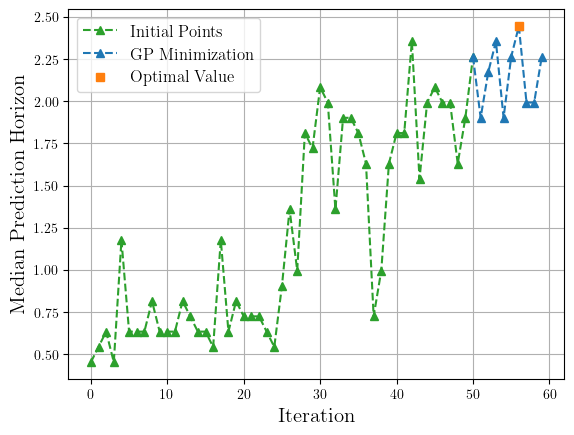

In [52]:
a = n_initial_points + len(x0)
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(func_iters.shape[0])

if a > 0:
    plt.plot(
        -func_iters[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, func_iters.shape[0])
plt.plot(
    xplot,
    -func_iters[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
plt.plot([optim_idx], [-func_iters[optim_idx]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Median Prediction Horizon', fontsize=15)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/median_PH.pdf', bbox_inches='tight', dpi=300)
plt.show()

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

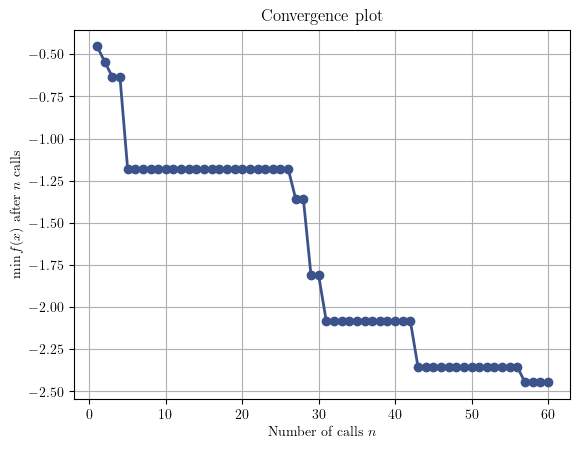

In [53]:
from skopt.plots import plot_convergence
plot_convergence(res)

In [54]:
optimized_vals_dict = {
    'x_iters':x_iters,
    'func_iters':func_iters,
    'optim_x':optim_x,
    'optim_idx':optim_idx,
    'optim_fun':func_iters[optim_idx]
}

with open(dir_name_rnn+'/optimized_vals.txt', 'w') as f:
    f.write(str(optimized_vals_dict))
    
np.savez(
    dir_name_rnn+'/optimized_vals',
    x_iters=x_iters,
    func_iters=func_iters,
    optim_x=optim_x,
    optim_idx=optim_idx,
    optim_fun=func_iters[optim_idx]
)

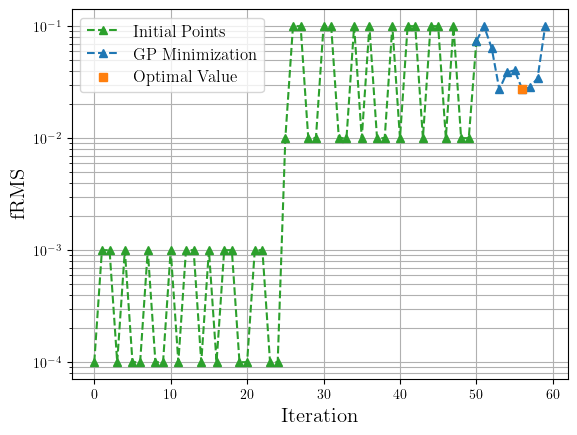

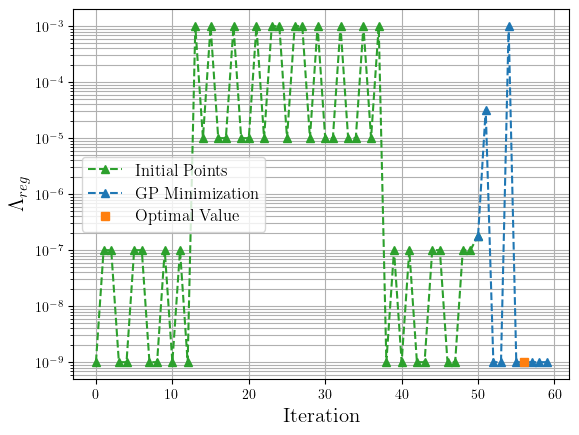

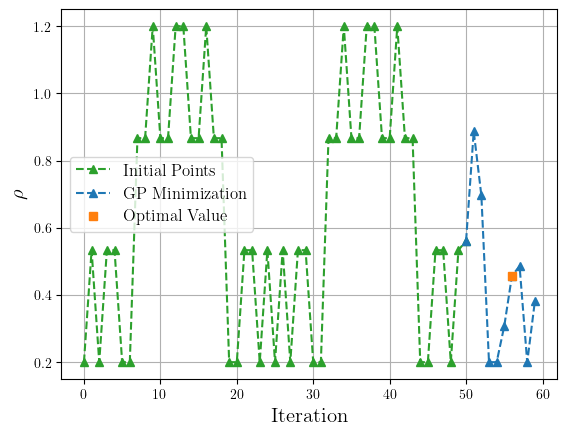

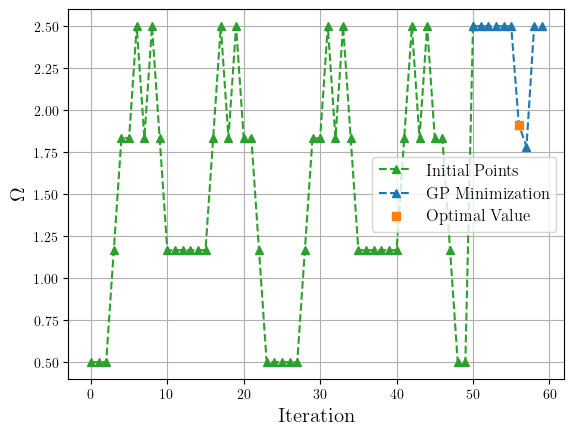

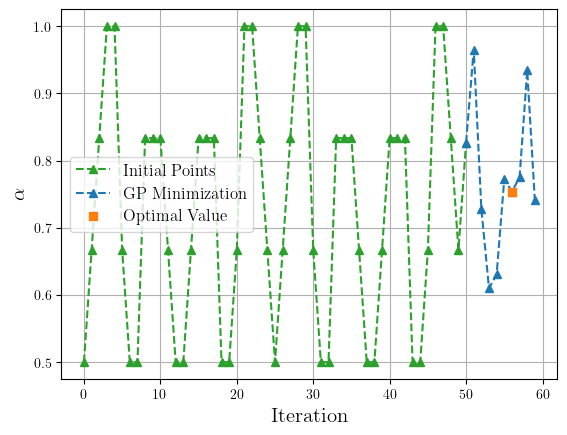

In [55]:
xoptim_names = [
    [r'fRMS', 'fRMS', plt.semilogy],
    [r'$\Lambda_{reg}$', 'lambda_reg', plt.semilogy],
    [r'$\rho$', 'rho', plt.plot],
    [r'$\Omega$', 'omega', plt.plot],
    [r'$\alpha$', 'alpha', plt.plot],
]
if vary_deg_connect == True:
    xoptim_names.append([r'Degree of Connectivity', 'deg_of_connectivity', plt.plot])

for i in range(len(xoptim_names)):
    a = n_initial_points + len(x0)
    # sorted_idx = np.argsort(x_iters[a:, 0])

    xplot = np.arange(x_iters.shape[0])
    if a > 0:
        xoptim_names[i][2](
            x_iters[:, i][0:a+1],
            linestyle='--',
            color='C2',
            marker='^',
            label='Initial Points',
        )
        xplot = np.arange(a, x_iters.shape[0])
    xoptim_names[i][2](
        xplot,
        x_iters[:, i][a:],
        linestyle='--',
        marker='^',
        label='GP Minimization',#'__nolegend__',
    )
    xoptim_names[i][2]([optim_idx], [x_iters[optim_idx, i]], 's', label='Optimal Value')

    plt.xlabel('Iteration', fontsize=15)
    plt.ylabel(xoptim_names[i][0], fontsize=15)
    plt.grid(True, which='major', axis='x')
    plt.grid(True, which='both', axis='y')
    plt.legend(fontsize=12)

    plt.savefig(dir_name_rnn_plots+'/'+xoptim_names[i][1]+'.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [56]:
dir_list = os.listdir(dir_name_rnn+'/tested_ESN')
# dir_list

In [60]:
ph_mean_lst = []
for dir_name in dir_list:
    with np.load(dir_name_rnn+'/tested_ESN/'+dir_name+'/prediction_horizons-testingdata--combinedAERNN--ZEROoutsteps.npz') as f:
        ph_mean = np.mean(f['prediction_horizon_arr'])
        ph_mean_lst.append(ph_mean)
ph_mean_lst = np.array(ph_mean_lst)

In [61]:
idx = np.where(ph_mean_lst == ph_mean_lst.max())[0]

In [62]:
idx, dir_list[idx[0]]

(array([5]), 'test_ESN_057')

In [63]:
# convergence plot
convergence_f = np.empty_like(func_iters)
min_val = np.inf
for i in range(func_iters.shape[0]):
    if func_iters[i] < min_val:
        min_val = func_iters[i]
    convergence_f[i] = min_val

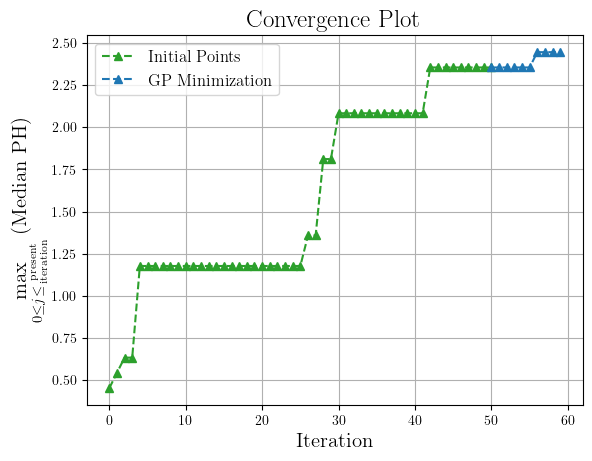

In [64]:
a = n_initial_points + len(x0)
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(x_iters.shape[0])

if a > 0:
    plt.plot(
        -convergence_f[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, x_iters.shape[0])
plt.plot(
    xplot,
    -convergence_f[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
# plt.semilogy([optim_idx], [func_iters[optim_idx, 0]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel(
#     r"$$\min_{0 \leq j \leq \mathrm{present \ iteration}} \left( \mathrm{Test \ MSE} \right)$$",
#     r"$$\min_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Test \ MSE} \right)$$",
    r"$$\max_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Median \ PH} \right)$$",
    fontsize=15,
)
plt.title('Convergence Plot', fontsize=18)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/convergence_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()

### Prediction horizon computation